#### Notebook to split FOUNDIN-PD RNAB by day
will also output a normalized covariate adjusted file for full dataset; ie across days

In [1]:
!date

Thu Feb 18 18:01:30 UTC 2021


#### do imports and set notebooks variables

In [2]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
# import threading
import concurrent.futures
import random
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.stats.multitest as smm
from umap import UMAP
import ppscore as pps
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [3]:
# naming
cohort = 'foundin'
quant_type = 'vst'

# directories
wrk_dir = f'/home/jupyter/{cohort}/eqtl'
expr_dir = f'{wrk_dir}/expression'
info_dir = f'{wrk_dir}/sample_info'

# files
all_expr_file = f'{expr_dir}/{cohort}.{quant_type}.genes.hdf5'
quants_local_file = f'{expr_dir}/{quant_type}.genes.tsv'
gencode_pkl = f'{expr_dir}/gencode_v29.lncipedia_v5_2_hc.annotation.pkl'
covariates_file = f'{info_dir}/foundin_rnab_sample_info.csv'
umap_covs_file = f'{info_dir}/foundin_rnab.umap.covs.csv'
norm_file = f'{expr_dir}/{cohort}.{quant_type}.norm.genes.hd5f'
adj_expr_file = f'{expr_dir}/{cohort}.{quant_type}.norm.adj.hdf5'
tnsrqtl_pheno_file = f'{expr_dir}/{cohort}.{quant_type}.norm.adj.bed'
feature_ids_exclude_var_file = f'{expr_dir}/{cohort}.{quant_type}.variance.features.exclude.txt'

# gene file of genes to exclude from variance detection
# using Human Protein Atlas 'elevated' gene set for braim
tissue_genes_file = f'{expr_dir}/tissue_category_rna_brain_Tissue.tsv'

# constants
max_missing_rate = 0.25
min_ppscore = 0.05
min_pearson = 0.22

other_id_columns = ['sampleid', 'cdi', 'PPMI_ID', 'DZNE_Barcode', 'DZNE_ID', 
                    'participant_id', 'wgsid', 'PATNO', 'Barcode_LNG', 
                    'Barcode_DZNE', 'Alternate MRN', 'IID', 'FID']
# to match geno's use PPMI3966 Batch3
replace_id_dict = {'PPMI3966B3': 'PPMI3966'}

### notebook functions

#### functions for detection rates calculations and plotting

In [4]:
def calculate_detection_rates(this_df, quant_type, round_percision=1, 
                              min_expr_value=None):
    if min_expr_value is None:
        min_expr_value = expr_df.round(round_percision).min().min()

    print(f'minimun {quant_type} value is {min_expr_value}')

    detected_df = this_df.mask(this_df.round(round_percision) <= min_expr_value, 0)

    # calculate the missing counts from the detected df mask
    trait_missing_rates = round(detected_df.isin({0}).sum(0)/detected_df.shape[0], 2)
    sample_missing_rates = round(detected_df.isin({0}).sum(1)/detected_df.shape[1], 2)

    print(f'{len(trait_missing_rates)} features with mean missing \
rate = {trait_missing_rates.mean()}')
    print(f'{len(sample_missing_rates)} samples with mean missing \
rate = {sample_missing_rates.mean()}')
    return trait_missing_rates, sample_missing_rates

def plot_missing_rates(feature_rates, sample_rates):
    sns.set()
    plt.figure(figsize=(12, 12))
    plt.subplot(2, 2, 1)
    sns.distplot(feature_rates.values)
    plt.title('Features missingness rates')
    plt.subplot(2, 2, 2)
    sns.distplot(sample_rates.values)
    plt.title('Samples missingness rates')
    plt.show()
    
def bad_callrate_features(features_missing_rates, max_missing_rate):
    bad_call_rates = features_missing_rates[features_missing_rates > max_missing_rate]
    print(f'features with bad call rates shape {bad_call_rates.shape}, \
fraction of features with bad rates {bad_call_rates.shape[0]/expr_df.shape[1]}')
    return bad_call_rates

def subset_well_detected_features(this_df, bad_call_rates):
    detected_traits = list(set(this_df.columns)-set(bad_call_rates.index))
    this_wd_df = this_df[detected_traits]
    print(f'shape of well detected quants {this_wd_df.shape}')
    return this_wd_df

#### function to generate and visualize known and unknow covariates using UMAP and PPScore

In [5]:
# function for plotting umap of traits with covar high lights
def plot_umap_clusters(umap_df, hue_cov=None, style_cov=None, size_cov=None):
    # umap_plot_file = f'{WRKDIR}/{COHORTBUILD}.umap.residuals.umap.plot.png'
    sns.set()
    plt.figure(figsize=(6,6))
    sns_plot = sns.scatterplot(x='x_umap',y='y_umap', \
                               hue=hue_cov, style=style_cov, size=size_cov, \
                               data=umap_df)
    plt.xlabel('x-umap')
    plt.ylabel('y-umap')
    #plt.legend(loc='lower right', prop={'size': 6})
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0,prop={'size': 6})
    # plt.savefig(umap_plot_file,format='png',dpi=600,bbox_inches='tight')
    plt.show()

# small function to generate umap from pandas dataframe, for all features (columns) \
# and return back as dataframe with source index intact
def generate_umap_covs_df(this_df, other_covs_df=None, 
                             rnd_digits=3, merge_input=False):
    #run UMAP on the data frame features
    umap_results = UMAP(random_state=42).fit_transform(this_df)
    umap_df = pd.DataFrame(umap_results,columns=['x_umap','y_umap'], \
                                       index=this_df.index).round(rnd_digits)
    if merge_input:
        umap_df = umap_df.merge(this_df,left_index=True,right_index=True)
    if other_covs_df is not None:
        umap_df = umap_df.merge(other_covs_df, how='left', 
                                left_index=True, right_index=True)
    print(f'The dimensions of the umap df and the traits are {umap_df.shape}')
    return umap_df 

# function to iterate over target features and use PPScore to find covarites of interest
def pps_predict_targets(this_df, target_list):
    covs_to_check = []
#     covs_list = ['x_umap', 'y_umap']
    for this_cov in target_list:
        print(this_cov)
        predictors_df = pps.predictors(this_df, this_cov)
        # drop anything that has ppscore of zero
        predictors_df = predictors_df.loc[predictors_df['ppscore'] > min_ppscore]
        display(predictors_df)
        covs_to_check.extend(list(predictors_df['x'].values))

    print(f'found {len(covs_to_check)} covariates that may preditct target covariates')    
    return covs_to_check

# plot ppscore matrix 
def plot_ppscore_matrix(this_df, covs_to_check, cov_targets):
    matrix_df = pps.matrix(this_df[(set(covs_to_check) | set(cov_targets))])
    matrix_df = matrix_df.loc[matrix_df['ppscore'] > min_ppscore]
    print(matrix_df.shape)

    matrix_df['ppscore'] = matrix_df['ppscore'].round(2)
    plot_matrix_df = matrix_df[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
    print(plot_matrix_df.shape)
    # display(plot_matrix_df)

    plt.figure(figsize=(plot_matrix_df.shape[0],plot_matrix_df.shape[1])) 
    sns.heatmap(plot_matrix_df, vmin=0, vmax=1, cmap='Blues', linewidths=0.05, 
                annot=True, annot_kws={'fontsize':12})
    plt.title('PPScore heatmap')
    plt.show()
    
# plot heatmap of Pearson correlation matrix for PPScore covariates
def plot_correlation_heatmap(this_df, covs_list : list=None):
    sns.set()
    cor = this_df.corr(method='pearson')
    cor.dropna(how='all', inplace=True)
    modified_title = ''
    if covs_list is not None:
        
        limited_cor = cor[covs_list]
        cor = limited_cor.loc[(limited_cor['x_umap'].abs() > min_pearson) | 
                              (limited_cor['y_umap'].abs() > min_pearson)]
        modified_title = 'limited'
    print(cor.shape)
    fig_width = cor.shape[1] if cor.shape[1] > 6 else 6
    fig_height = cor.shape[0] if cor.shape[1] > 6 else 6
    plt.figure(figsize=(fig_width, fig_height))        
    sns.heatmap(cor[(cor > min_pearson) | (cor < -min_pearson)], annot=True, 
                annot_kws={"fontsize":10}, linewidths=0.05, cmap='Blues')    
    plt.title(f'Pearson heatmap of PPScore covariates {modified_title}')
    plt.show()

# function to one-hot encode the categorical covariates and merge with continuous ones    
def dummy_covs_as_needed(this_df):
    temp_df = this_df.copy()
    cats_df = temp_df.select_dtypes(include=['object'])
    print(f'categoricals shape {cats_df.shape}')
    dums_df = pd.get_dummies(cats_df)
    print(f'one-hot encoded categoricals shape {dums_df.shape}')

    temp_df = temp_df.merge(dums_df, how='inner', left_index=True, right_index=True)
    print(f'new covs df shape {temp_df.shape}')
    return temp_df    

#### visualization functions

In [6]:
# small function to plot before and after of transform based on named feature,
# or if a feature isn't specified then one pull at random
def plot_trnsfrm_effect_example(before_df, after_df, feature_id=None,
                                bf_label='quantile transformed', 
                                af_label='quantile transformed and covariate adjusted'):
    # if no feature ID provided get randome one
    if feature_id is None:
        feature_id = random.sample(list(after_df.columns), 1)[0]
    
    sns.distplot(before_df[feature_id])
    plt.title(f'{feature_id} {bf_label}')
    plt.show()
    sns.distplot(after_df[feature_id])
    plt.title(f'{feature_id} {af_label}')
    plt.show()
    sns.scatterplot(x=before_df[feature_id], y=after_df[feature_id])
    plt.title(f'{feature_id}')
    plt.xlabel(f'{bf_label}')
    plt.ylabel(f'{af_label}')

#### analysis functions

In [7]:
# small function to perform the quantile transform on a pandas dataframe
def quantile_transform_df(this_df : pd.DataFrame):
    transformedX = preprocessing.quantile_transform(this_df, axis=0, copy=True, 
                                                    output_distribution='normal')
    transformed_df = pd.DataFrame(data=transformedX, columns=this_df.columns, 
                                 index=this_df.index)  
    return transformed_df

# exclude low variance genes from covariate generation
def exclude_low_var_features(this_df: pd.DataFrame, quartile_to_drop: str ='25%', 
                             known_feature_to_drop=None):
    quants_vars = this_df.var() 
    print(quants_vars.describe())
    # drop genes within the lower quartile of variance
    min_variance = quants_vars.describe()['25%']
    # min_variance = quants_vars.describe()['50%']
    keep = quants_vars[quants_vars > min_variance]
    if known_feature_to_drop is not None:
        keep_ids = set(keep.index) - set(known_feature_to_drop)
    else:
        keep_ids = set(keep.index)
    quants_wd_var_df = this_df[keep_ids]
    print(f'shape of the features to keep {keep.shape}')
    print(f'shape of input features df {this_df.shape}')
    print(f'shape of variance fatures df {quants_wd_var_df.shape}')
    return quants_wd_var_df

# function to fit linear model to covariates and calculate the standardized residuals
def covariate_residuals(traits_df, covars_df):
    lm = LinearRegression(n_jobs=16)
    residuals_df = traits_df.copy()
    covar_scores_by_trait = {}

    for trait in traits_df:
            model = lm.fit(covars_df, traits_df[trait])
            covar_scores_by_trait[trait] = model.score(covars_df,traits_df[trait])
            model_predicted = model.predict(covars_df)
            residuals_df[trait] = stats.zscore(traits_df[trait] - model_predicted)
            
#     # We can use a with statement to ensure threads are cleaned up promptly
#     with concurrent.futures.ProcessPoolExecutor() as ppe:
#         # Start the load operations and mark each future with its URL
#         future_to_residual = {executor.submit(compute_residuals, trait): trait for trait in traits_df}
#         for future in concurrent.futures.as_completed(future_to_residual):
#             covar_scores_by_trait[trait], residuals_df[trait] = future_to_residual[future]

    # grab the covariates model scores
    covar_scores_by_trait_df = pd.DataFrame.from_dict(covar_scores_by_trait,
                                                      columns=['score'],
                                                      orient='index').round(3)
    covar_scores_by_trait_df.index.name = 'geneID'
    return residuals_df, covar_scores_by_trait_df


#### input output functions

In [8]:
# small function to save hdf file
def write_df_to_hdf(this_df, file_name, key='quants', mode='w'):
    this_df.to_hdf(file_name, key=key, mode=mode)

#### load the expression matrix

In [9]:
%%time
expr_dd = dd.read_csv(quants_local_file, sep='\s+').set_index('Geneid')
print(expr_dd.shape)

expr_df = expr_dd.compute().transpose()
print(expr_df.shape)

# now save the transposed expr matrix in faster file type
expr_df.to_hdf(all_expr_file, key='quants', mode='w')
# display(expr_df.head())

(Delayed('int-971712f9-1230-486e-9db1-b8ca45afdb89'), 301)
(301, 94946)
CPU times: user 16.8 s, sys: 2.99 s, total: 19.8 s
Wall time: 5.95 s


In [ ]:
# expr_df[['DHRSX-IT1','ENSG00000223571.6_PAR_Y']]

#### split name index to find info

In [11]:
id_parts = expr_df.index.str.split('_', expand=True).to_frame()
id_parts.columns = ['assay', 'sampleid', 'cdi', 'day', 'version']
id_parts['assayid'] = expr_df.index
print(id_parts.shape)
# display(id_parts.sample(5))

(301, 6)


#### capture the assayid to wgsid for formatting phenotypes for use with wgs genotypes later

In [12]:
id_map = id_parts[['sampleid', 'assayid']]
id_map['sampleid'].replace(replace_id_dict, inplace=True)

#### load covariates files

In [13]:
covs_df = pd.read_csv(covariates_file, index_col=0)
print(covs_df.shape)
# display(covs_df.sample(5))

(305, 98)


In [14]:
# check for any unexpected samples; ie probably name frmt issue
set(id_parts['assayid']) - set(covs_df.index)

{'RNAB_PPMI3422_1260_da65_v1',
 'RNAB_PPMI3448_2397_da25_v1',
 'RNAB_PPMI3448_2397_da65_v1',
 'RNAB_PPMI3451_3236_da25_v1',
 'RNAB_PPMI3451_3236_da65_v1',
 'RNAB_PPMI3664_2833_da65_v1',
 'RNAB_PPMI3665_4484_da0_v1',
 'RNAB_PPMI3665_4484_da25_v1',
 'RNAB_PPMI3665_4484_da65_v1',
 'RNAB_PPMI3953_6647_da65_v1',
 'RNAB_PPMI3966B5E6_2813_da0_v1',
 'RNAB_PPMI3966B5E6_2813_da25_v1',
 'RNAB_PPMI3966B5E6_2813_da65_v1',
 'RNAB_PPMI3966B5E8_2813_da0_v1',
 'RNAB_PPMI3966B5E8_2813_da25_v1',
 'RNAB_PPMI3966B5E8_2813_da65_v1',
 'RNAB_PPMI4101_7215_da0_v2',
 'RNAB_PPMI4101_7215_da25_v1',
 'RNAB_PPMI4101_7215_da65_v2',
 'RNAB_PPMI4106_0494_da65_v1',
 'RNAB_PPMI54991_0683_da65_v1'}

In [15]:
set(id_parts['sampleid']) - set(covs_df['sampleid'])

{'PPMI3966B1', 'PPMI3966B2', 'PPMI3966B3', 'PPMI3966B5E6', 'PPMI3966B5E8'}

#### for further analysis remove the ID columns

In [16]:
print(covs_df.shape)
cols_to_keep = set(covs_df.columns) - set(other_id_columns)
covs_df = covs_df[cols_to_keep]
print(covs_df.shape)
# display(covs_df.head())

(305, 98)
(305, 85)


#### load feature annotations

also need to fix gene IDs, since they are names instead of IDs
the non-coding gene names can include hyphens and unfortunately plink cmd line doesn't like pheno names with hyphens I guess because it uses for range of phenos maybe

looks like the custom lncRNA data added the name was used as ID and name col is missing, so for these switch name to name and then modify ID so that hyphens become underscores

In [17]:
gencode_df = pd.read_pickle(gencode_pkl)
print(gencode_df.shape)

(3072652, 50)


In [18]:
# if not already fixed
if gencode_df['gene_name'].isna().sum() > 0:
    # for missing gene names set them to the id (which is the actual name)
    where_name_missing = gencode_df['gene_name'].isna()
    gencode_df.loc[where_name_missing, 'gene_name'] = gencode_df['gene_id']
    # now remove hyphens from those IDs
    gencode_df.loc[where_name_missing, 'gene_id'] = gencode_df['gene_id'].str.replace('-', '_')
    # now save new gencode pickle
    gencode_df.to_pickle(gencode_pkl)

# now replace gene names in expression matrix columns with IDs
gene_id_map = gencode_df[['gene_name', 'gene_id']].drop_duplicates(keep='first')
print(gene_id_map.shape)
gene_id_name_dict = dict(zip(gene_id_map['gene_name'], gene_id_map['gene_id']))
expr_df.rename(columns=gene_id_name_dict, inplace=True)
print(expr_df.iloc[:, expr_df.columns.duplicated()].columns)
expr_df = expr_df.loc[:,~expr_df.columns.duplicated()]
print(expr_df.shape)
expr_df.to_hdf(all_expr_file, key='quants', mode='w')    

(94946, 2)
Index(['ENSG00000223571.6_PAR_Y', 'ENSG00000230542.6_PAR_Y',
       'ENSG00000236871.7_PAR_Y', 'ENSG00000226179.6_PAR_Y'],
      dtype='object', name='Geneid')
(301, 94942)


#### find IDs for features on sex chromosomes, for dropping later

In [19]:
sex_chr_gene_ids = gencode_df.loc[gencode_df['seqname'].isin(['chrX', 'chrY'])]['gene_id'].unique()

#### get counts by day

In [20]:
days = id_parts['day'].value_counts()
for day, count in days.items():
    print(f'{day} {count}')

da25 106
da0 99
da65 96


#### save the expression matrix split by day

In [21]:
%%time
# run the saves in parallel    
with concurrent.futures.ThreadPoolExecutor() as tpe:
    for day in days.index:
        day_df = id_parts.loc[id_parts['day'] == day]
        this_expr_df = expr_df[expr_df.index.isin(day_df['assayid'])]
        print(f'{cohort} {day} {this_expr_df.shape}')
        cohort_expr_filename = f'{expr_dir}/{cohort}.{day}.{quant_type}.genes.hdf5'
        tpe.submit(write_df_to_hdf, this_expr_df, cohort_expr_filename)    

foundin da25 (106, 94942)
foundin da0 (99, 94942)
foundin da65 (96, 94942)
CPU times: user 461 ms, sys: 205 ms, total: 666 ms
Wall time: 656 ms


#### standardize the full dataset using quantile transform

In [22]:
%%time
traits_qtnorm_df = quantile_transform_df(expr_df)

CPU times: user 1min 16s, sys: 203 ms, total: 1min 16s
Wall time: 1min 16s


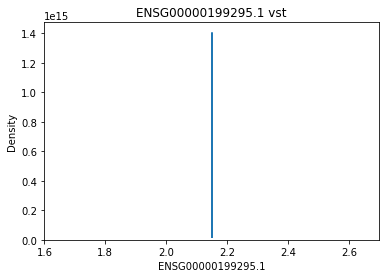

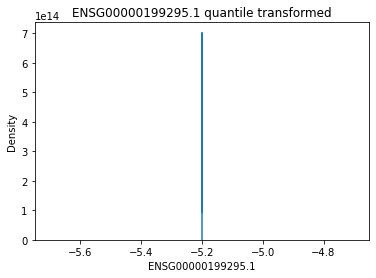

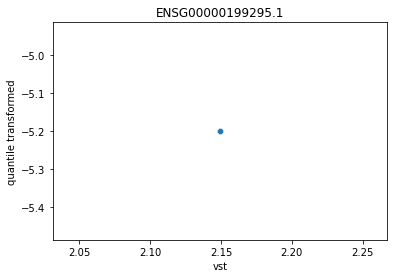

In [23]:
plot_trnsfrm_effect_example(expr_df, traits_qtnorm_df,
                            bf_label=quant_type, 
                            af_label='quantile transformed')

### generate covariates for variance

#### load tissue elevated genes to remove from variance consideration

In [24]:
tissue_genes_df = pd.read_csv(tissue_genes_file, sep='\t')
print(tissue_genes_df.shape)
# display(tissue_genes_df.sample(5))

(2587, 290)


In [25]:
# the protein atlas data file includes the ensembl IDs without version, handle that
gene_id_unversions = gencode_df['gene_id'].str.split('.', expand=True)
gene_id_unversions.columns = ['ensembl', 'version']
gene_id_unversions['ensemblid'] = gencode_df['gene_id']
gene_id_unversions['gene_name'] = gencode_df['gene_name']
print(gene_id_unversions.shape)
# display(gene_id_unversions.sample(5))

(3072652, 4)


In [26]:
tissue_gene_ids = gene_id_unversions.loc[gene_id_unversions['ensembl'].
                                         isin(tissue_genes_df['Ensembl'])]['ensemblid'].unique()
print(tissue_gene_ids.shape)
# display(tissue_gene_ids)
# save to feature IDs to exclude from variance detection
pd.DataFrame(tissue_gene_ids, columns=['id']).to_csv(feature_ids_exclude_var_file, 
                                                     index=False)

(2591,)


In [27]:
type(tissue_gene_ids)

numpy.ndarray

#### calculate, plot detection rates and subset well detected expression

minimun vst value is 2.1
94942 features with mean missing rate = 0.5832074319058013
301 samples with mean missing rate = 0.5831561461794024


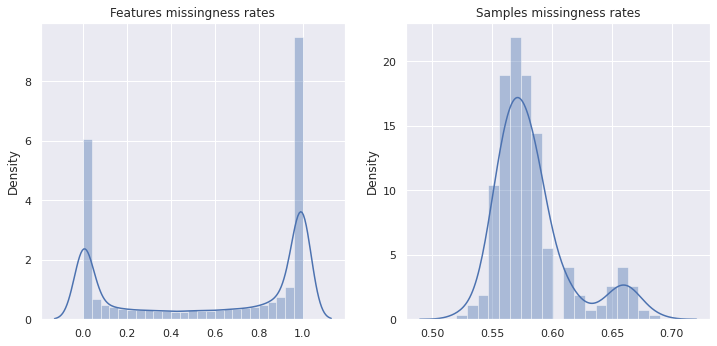

features with bad call rates shape (62834,), fraction of features with bad rates 0.6618145815339892
shape of well detected quants (301, 32108)
CPU times: user 34.4 s, sys: 393 ms, total: 34.8 s
Wall time: 33.4 s


In [28]:
%%time
trait_miss_rates, sample_miss_rates = calculate_detection_rates(expr_df, quant_type)
plot_missing_rates(trait_miss_rates, sample_miss_rates)
bad_call_rate_features = bad_callrate_features(trait_miss_rates, max_missing_rate)
traits_qtnorm_df = subset_well_detected_features(traits_qtnorm_df, bad_call_rate_features)

#### save quantile standardized, well detected data for all days

In [29]:
write_df_to_hdf(traits_qtnorm_df, norm_file)

#### take a look at variance in data, assuming mostly driven by d0 -> d25, ie IPSc -> differentiating neurons

#### exclude low variance genes from covariate generation

In [30]:
quants_var_df = exclude_low_var_features(traits_qtnorm_df)

count    32108.000000
mean         1.966343
std          1.431439
min          1.144478
25%          1.144478
50%          1.144478
75%          2.187048
max          6.485814
dtype: float64
shape of the features to keep (23122,)
shape of input features df (301, 32108)
shape of variance fatures df (301, 23122)


### take a look at the data

#### generate unknown covariates and see if know covariates are source of variations

The dimensions of the umap df and the traits are (301, 87)
x_umap


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,day,x_umap,0.852000,regression,True,mean absolute error,6.054654,0.896091,DecisionTreeRegressor()
1,ImmatureDopaminergicNeurons,x_umap,0.846358,regression,True,mean absolute error,6.054654,0.930250,DecisionTreeRegressor()
2,Ependymal-likeCells,x_umap,0.843878,regression,True,mean absolute error,6.054654,0.945262,DecisionTreeRegressor()
3,ProliferatingFloorPlateProgenitors,x_umap,0.830976,regression,True,mean absolute error,6.054654,1.023382,DecisionTreeRegressor()
4,DopaminergicNeurons,x_umap,0.825438,regression,True,mean absolute error,6.054654,1.056914,DecisionTreeRegressor()
5,EarlyneuronProgenitor,x_umap,0.822172,regression,True,mean absolute error,6.054654,1.076686,DecisionTreeRegressor()
6,LateneuronProgenitor,x_umap,0.732272,regression,True,mean absolute error,6.054654,1.621000,DecisionTreeRegressor()
7,y_umap,x_umap,0.597658,regression,True,mean absolute error,5.865355,2.359879,DecisionTreeRegressor()
8,Assigned,x_umap,0.225948,regression,True,mean absolute error,6.054654,4.686618,DecisionTreeRegressor()
9,ProperPairs,x_umap,0.102417,regression,True,mean absolute error,6.054654,5.434552,DecisionTreeRegressor()


y_umap


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,day,y_umap,0.647437,regression,True,mean absolute error,1.958721,0.690572,DecisionTreeRegressor()
1,x_umap,y_umap,0.403193,regression,True,mean absolute error,1.935379,1.155047,DecisionTreeRegressor()
2,ProliferatingFloorPlateProgenitors,y_umap,0.302944,regression,True,mean absolute error,1.958721,1.365339,DecisionTreeRegressor()
3,Ependymal-likeCells,y_umap,0.280546,regression,True,mean absolute error,1.958721,1.409210,DecisionTreeRegressor()
4,ImmatureDopaminergicNeurons,y_umap,0.230214,regression,True,mean absolute error,1.958721,1.507796,DecisionTreeRegressor()
5,DopaminergicNeurons,y_umap,0.227479,regression,True,mean absolute error,1.958721,1.513154,DecisionTreeRegressor()
6,EarlyneuronProgenitor,y_umap,0.177144,regression,True,mean absolute error,1.958721,1.611746,DecisionTreeRegressor()
7,LateneuronProgenitor,y_umap,0.114173,regression,True,mean absolute error,1.958721,1.735089,DecisionTreeRegressor()


found 20 covariates that may preditct target covariates
(125, 9)
(13, 13)


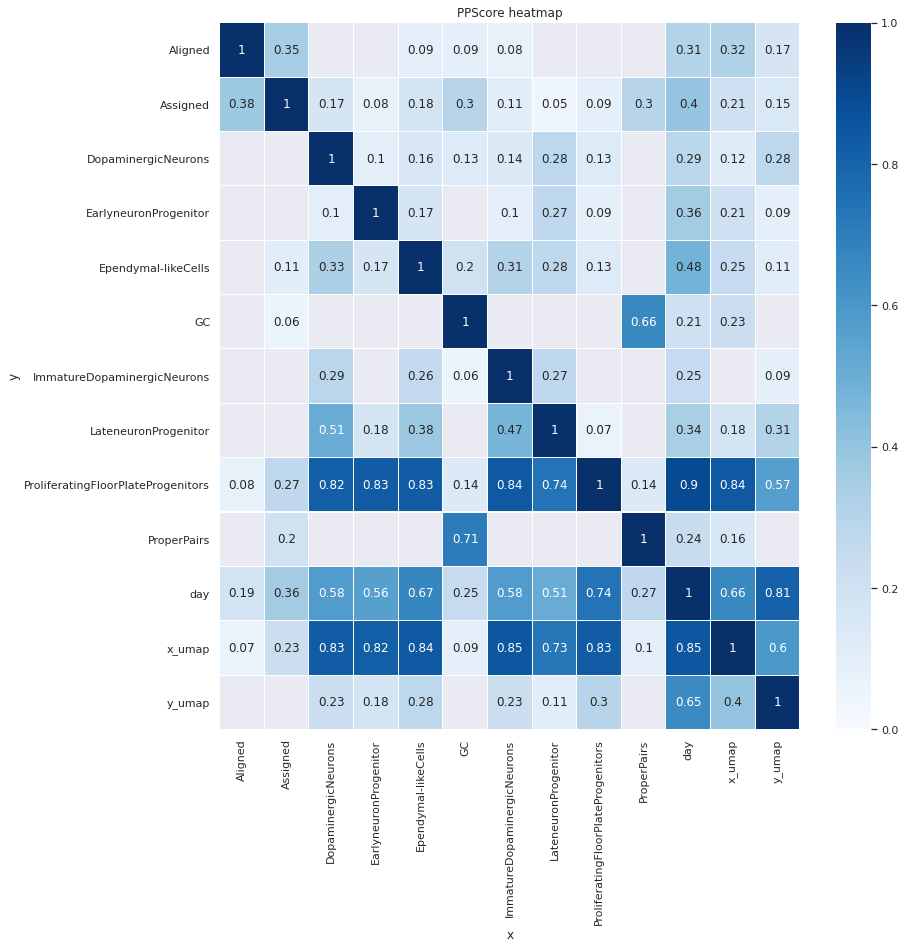

categoricals shape (301, 1)
one-hot encoded categoricals shape (301, 3)
new covs df shape (301, 16)
(15, 15)


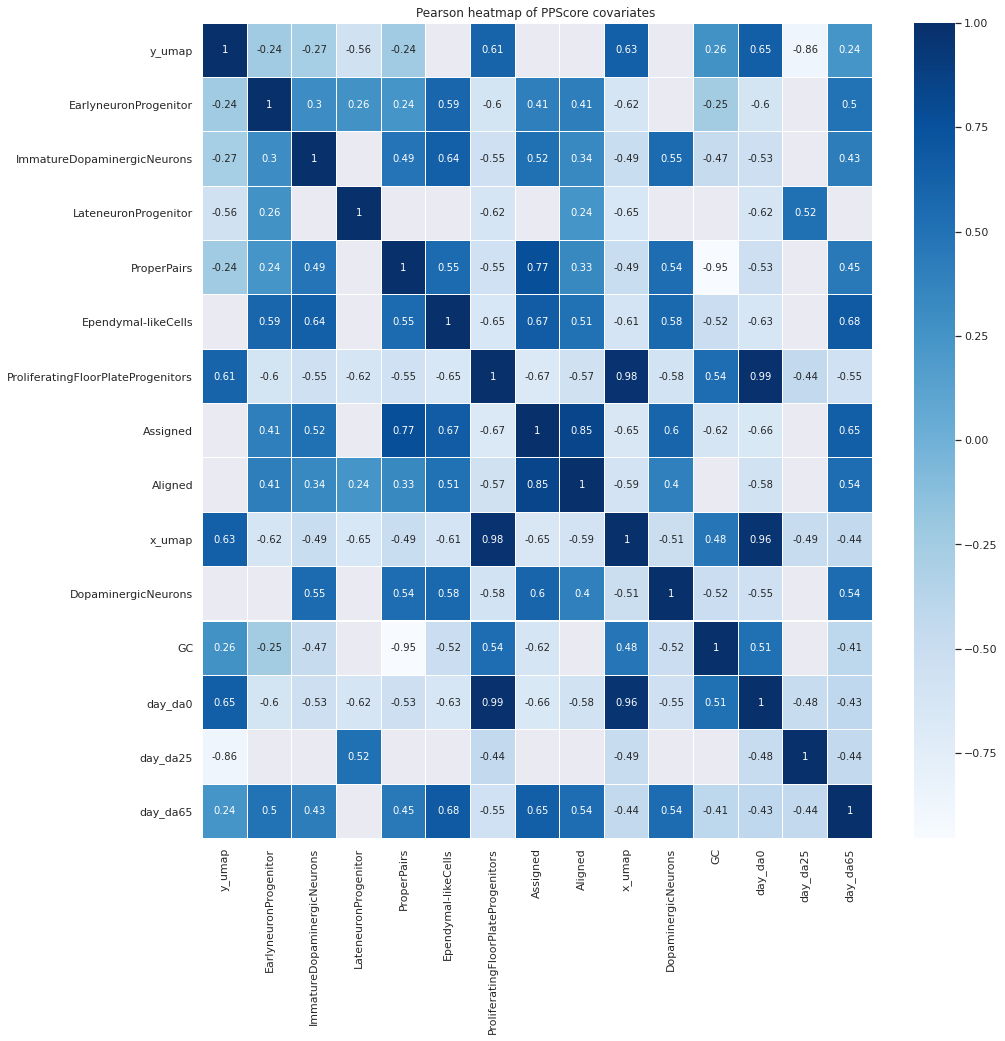

(15, 2)


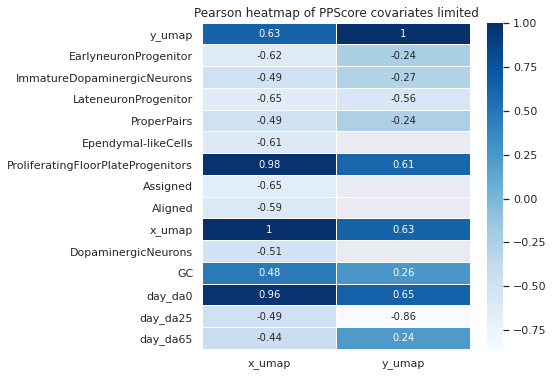

CPU times: user 13.9 s, sys: 218 ms, total: 14.1 s
Wall time: 14.1 s


In [31]:
%%time
umap_df = generate_umap_covs_df(quants_var_df, covs_df)
covs_target_list = ['x_umap', 'y_umap']
covs_to_check = pps_predict_targets(umap_df, covs_target_list)
plot_ppscore_matrix(umap_df, covs_to_check, covs_target_list)
umap_dums_covs_df = dummy_covs_as_needed(umap_df[(set(covs_to_check) | 
                                                  set(covs_target_list))])
plot_correlation_heatmap(umap_dums_covs_df)
plot_correlation_heatmap(umap_dums_covs_df, covs_target_list)

#### plot umap of with known covariates of interest

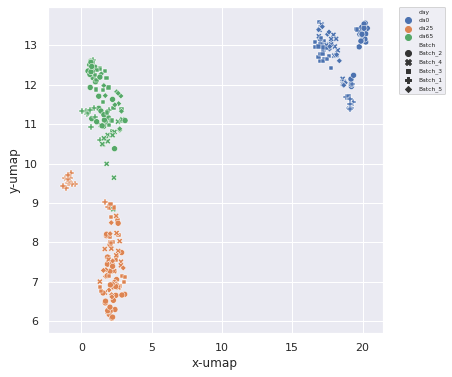

In [32]:
plot_umap_clusters(umap_df, hue_cov='day', style_cov='Batch')

#### do quick anova by day to identify features change with cell differentiation 

this is since we know differention should be largest source of variation, so figure out which features to exclude to get around

In [33]:
# split samples by group (day)
feats_by_day = {}
for day in days.index:
    day_df = id_parts.loc[id_parts['day'] == day]
    this_expr_df = traits_qtnorm_df[traits_qtnorm_df.index.isin(day_df['assayid'])]
    feats_by_day[day] = this_expr_df
    print(f'{cohort} {day} {this_expr_df.shape}')

# calculate one-way ANOVA for the groups
fvalues, pvalues = stats.f_oneway(feats_by_day.get('da0'), 
                                  feats_by_day.get('da25'), 
                                  feats_by_day.get('da65'))

# make df from results
anove_results_df = pd.DataFrame(data={'fvalues': fvalues, 'pvalues': pvalues}, 
                                index=traits_qtnorm_df.columns)
# apply a B&H FDR to pvalues
anove_results_df['bh_fdr'] = smm.fdrcorrection(pvalues)[1]

print(anove_results_df.shape)
display(anove_results_df.head())

foundin da25 (106, 32108)
foundin da0 (99, 32108)
foundin da65 (96, 32108)
(32108, 3)


,fvalues,pvalues,bh_fdr
Geneid,,,
ENSG00000127419.16,352.355507,3.041104e-79,1.914584e-77
lnc_SFTPC_2,10.874647,2.764354e-05,3.286477e-05
ENSG00000233380.1,5.627846,3.989200e-03,4.381829e-03
ENSG00000280214.1,52.977848,2.062988e-20,3.900508e-20
ENSG00000180758.11,21.043270,2.827458e-09,3.851840e-09


In [34]:
anove_results_df.loc[anove_results_df['bh_fdr'] < 0.05].shape

(30440, 3)

#### determine final set of features to use for variance detection
exluding bottom 25% variance features, sex features, tissue elevated features, and cell differentiation features

In [35]:
no_change_features = anove_results_df.loc[anove_results_df['bh_fdr'] > 0.05].index.values
print(len(no_change_features))

no_change_variance_features = ((set(no_change_features) & set(quants_var_df.columns)) 
                               - set(tissue_gene_ids)) - set(sex_chr_gene_ids)
print(len(no_change_variance_features))

1668
1354


#### generate unknown covariates from final set of features for variance detection

The dimensions of the umap df and the traits are (301, 87)
x_umap


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,Batch,x_umap,0.138166,regression,True,mean absolute error,0.783971,0.675654,DecisionTreeRegressor()
1,Differentiation_Start,x_umap,0.132160,regression,True,mean absolute error,0.783971,0.680361,DecisionTreeRegressor()
2,AGE_ONSET,x_umap,0.065228,regression,True,mean absolute error,0.820574,0.767050,DecisionTreeRegressor()
3,GC,x_umap,0.057579,regression,True,mean absolute error,0.783971,0.738831,DecisionTreeRegressor()


y_umap


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,Batch,y_umap,0.304345,regression,True,mean absolute error,1.463596,1.018158,DecisionTreeRegressor()
1,Differentiation_Start,y_umap,0.297181,regression,True,mean absolute error,1.463596,1.028643,DecisionTreeRegressor()
2,GC,y_umap,0.251328,regression,True,mean absolute error,1.463596,1.095754,DecisionTreeRegressor()
3,Dups,y_umap,0.178768,regression,True,mean absolute error,1.463596,1.201953,DecisionTreeRegressor()
4,Growth_iPSC,y_umap,0.147321,regression,True,mean absolute error,1.463596,1.247978,DecisionTreeRegressor()
5,PC9,y_umap,0.135895,regression,True,mean absolute error,1.468653,1.269070,DecisionTreeRegressor()
6,PC20,y_umap,0.129021,regression,True,mean absolute error,1.468653,1.279167,DecisionTreeRegressor()
7,PC13,y_umap,0.123438,regression,True,mean absolute error,1.468653,1.287366,DecisionTreeRegressor()
8,PC18,y_umap,0.114073,regression,True,mean absolute error,1.468653,1.301120,DecisionTreeRegressor()
9,MAP2_Santa_Cruz_ICC,y_umap,0.111571,regression,True,mean absolute error,1.439179,1.278609,DecisionTreeRegressor()


found 39 covariates that may preditct target covariates
(1027, 9)
(38, 38)


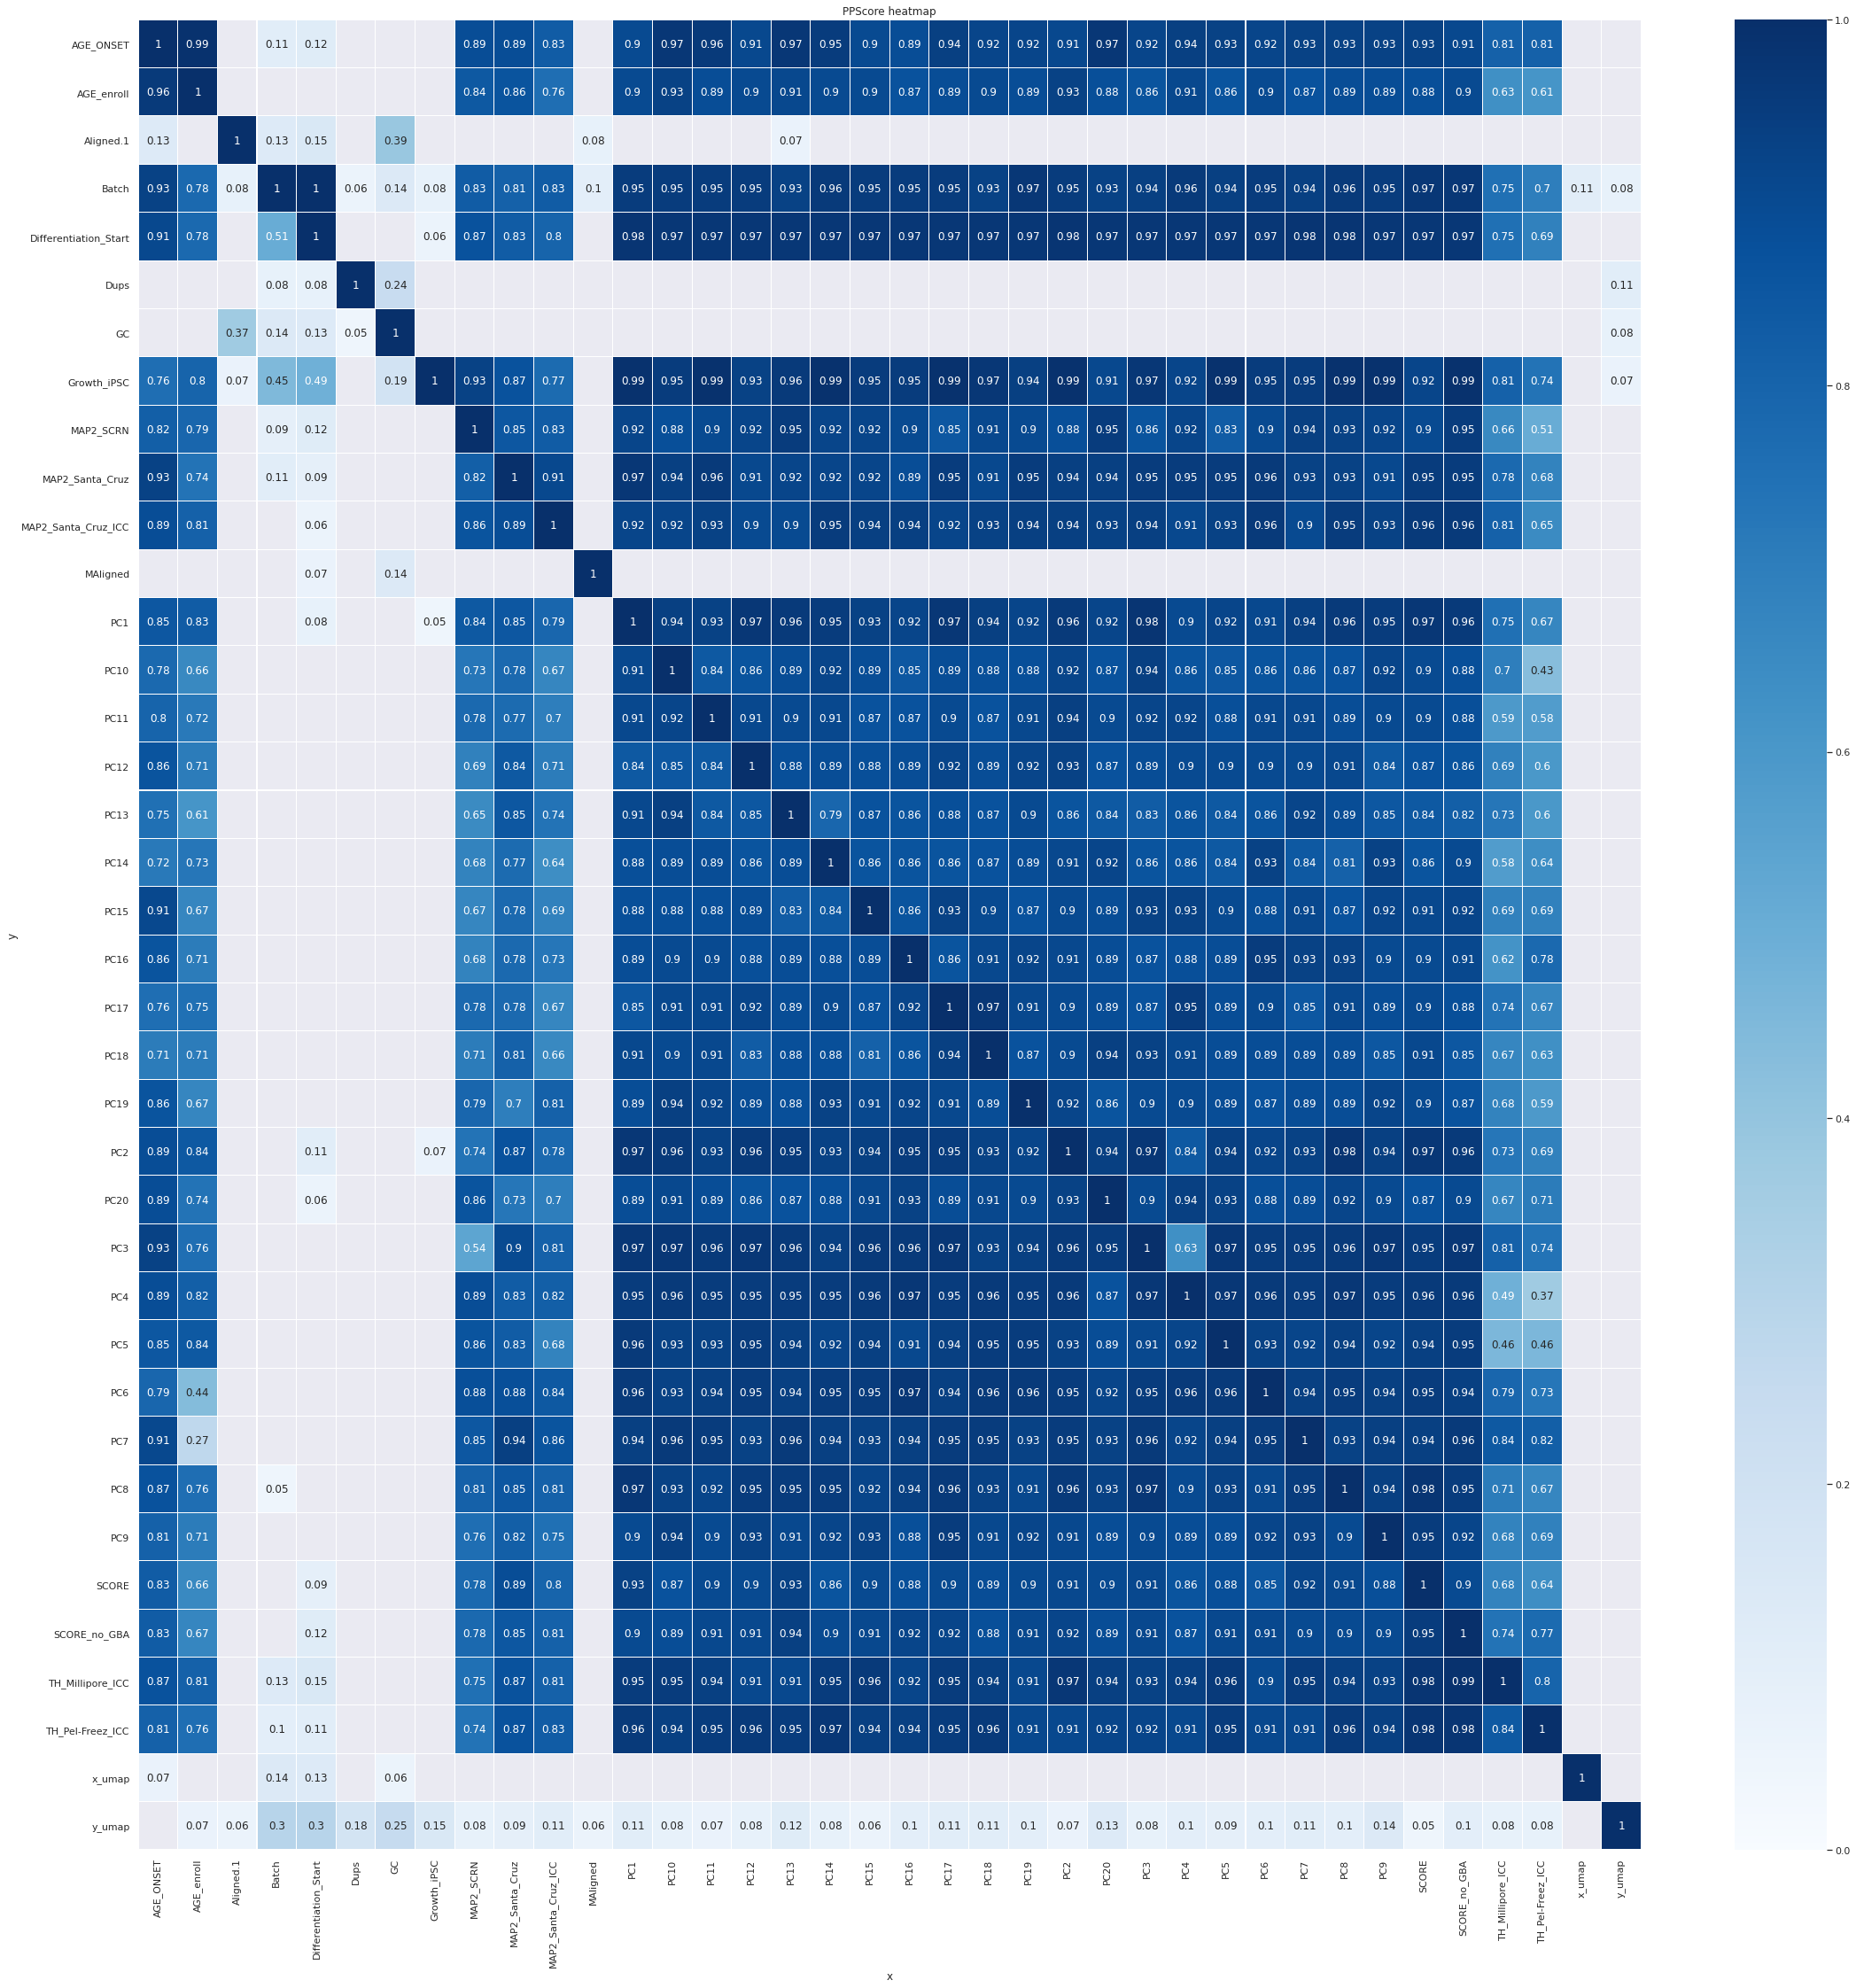

categoricals shape (301, 3)
one-hot encoded categoricals shape (301, 17)
new covs df shape (301, 55)
(52, 52)


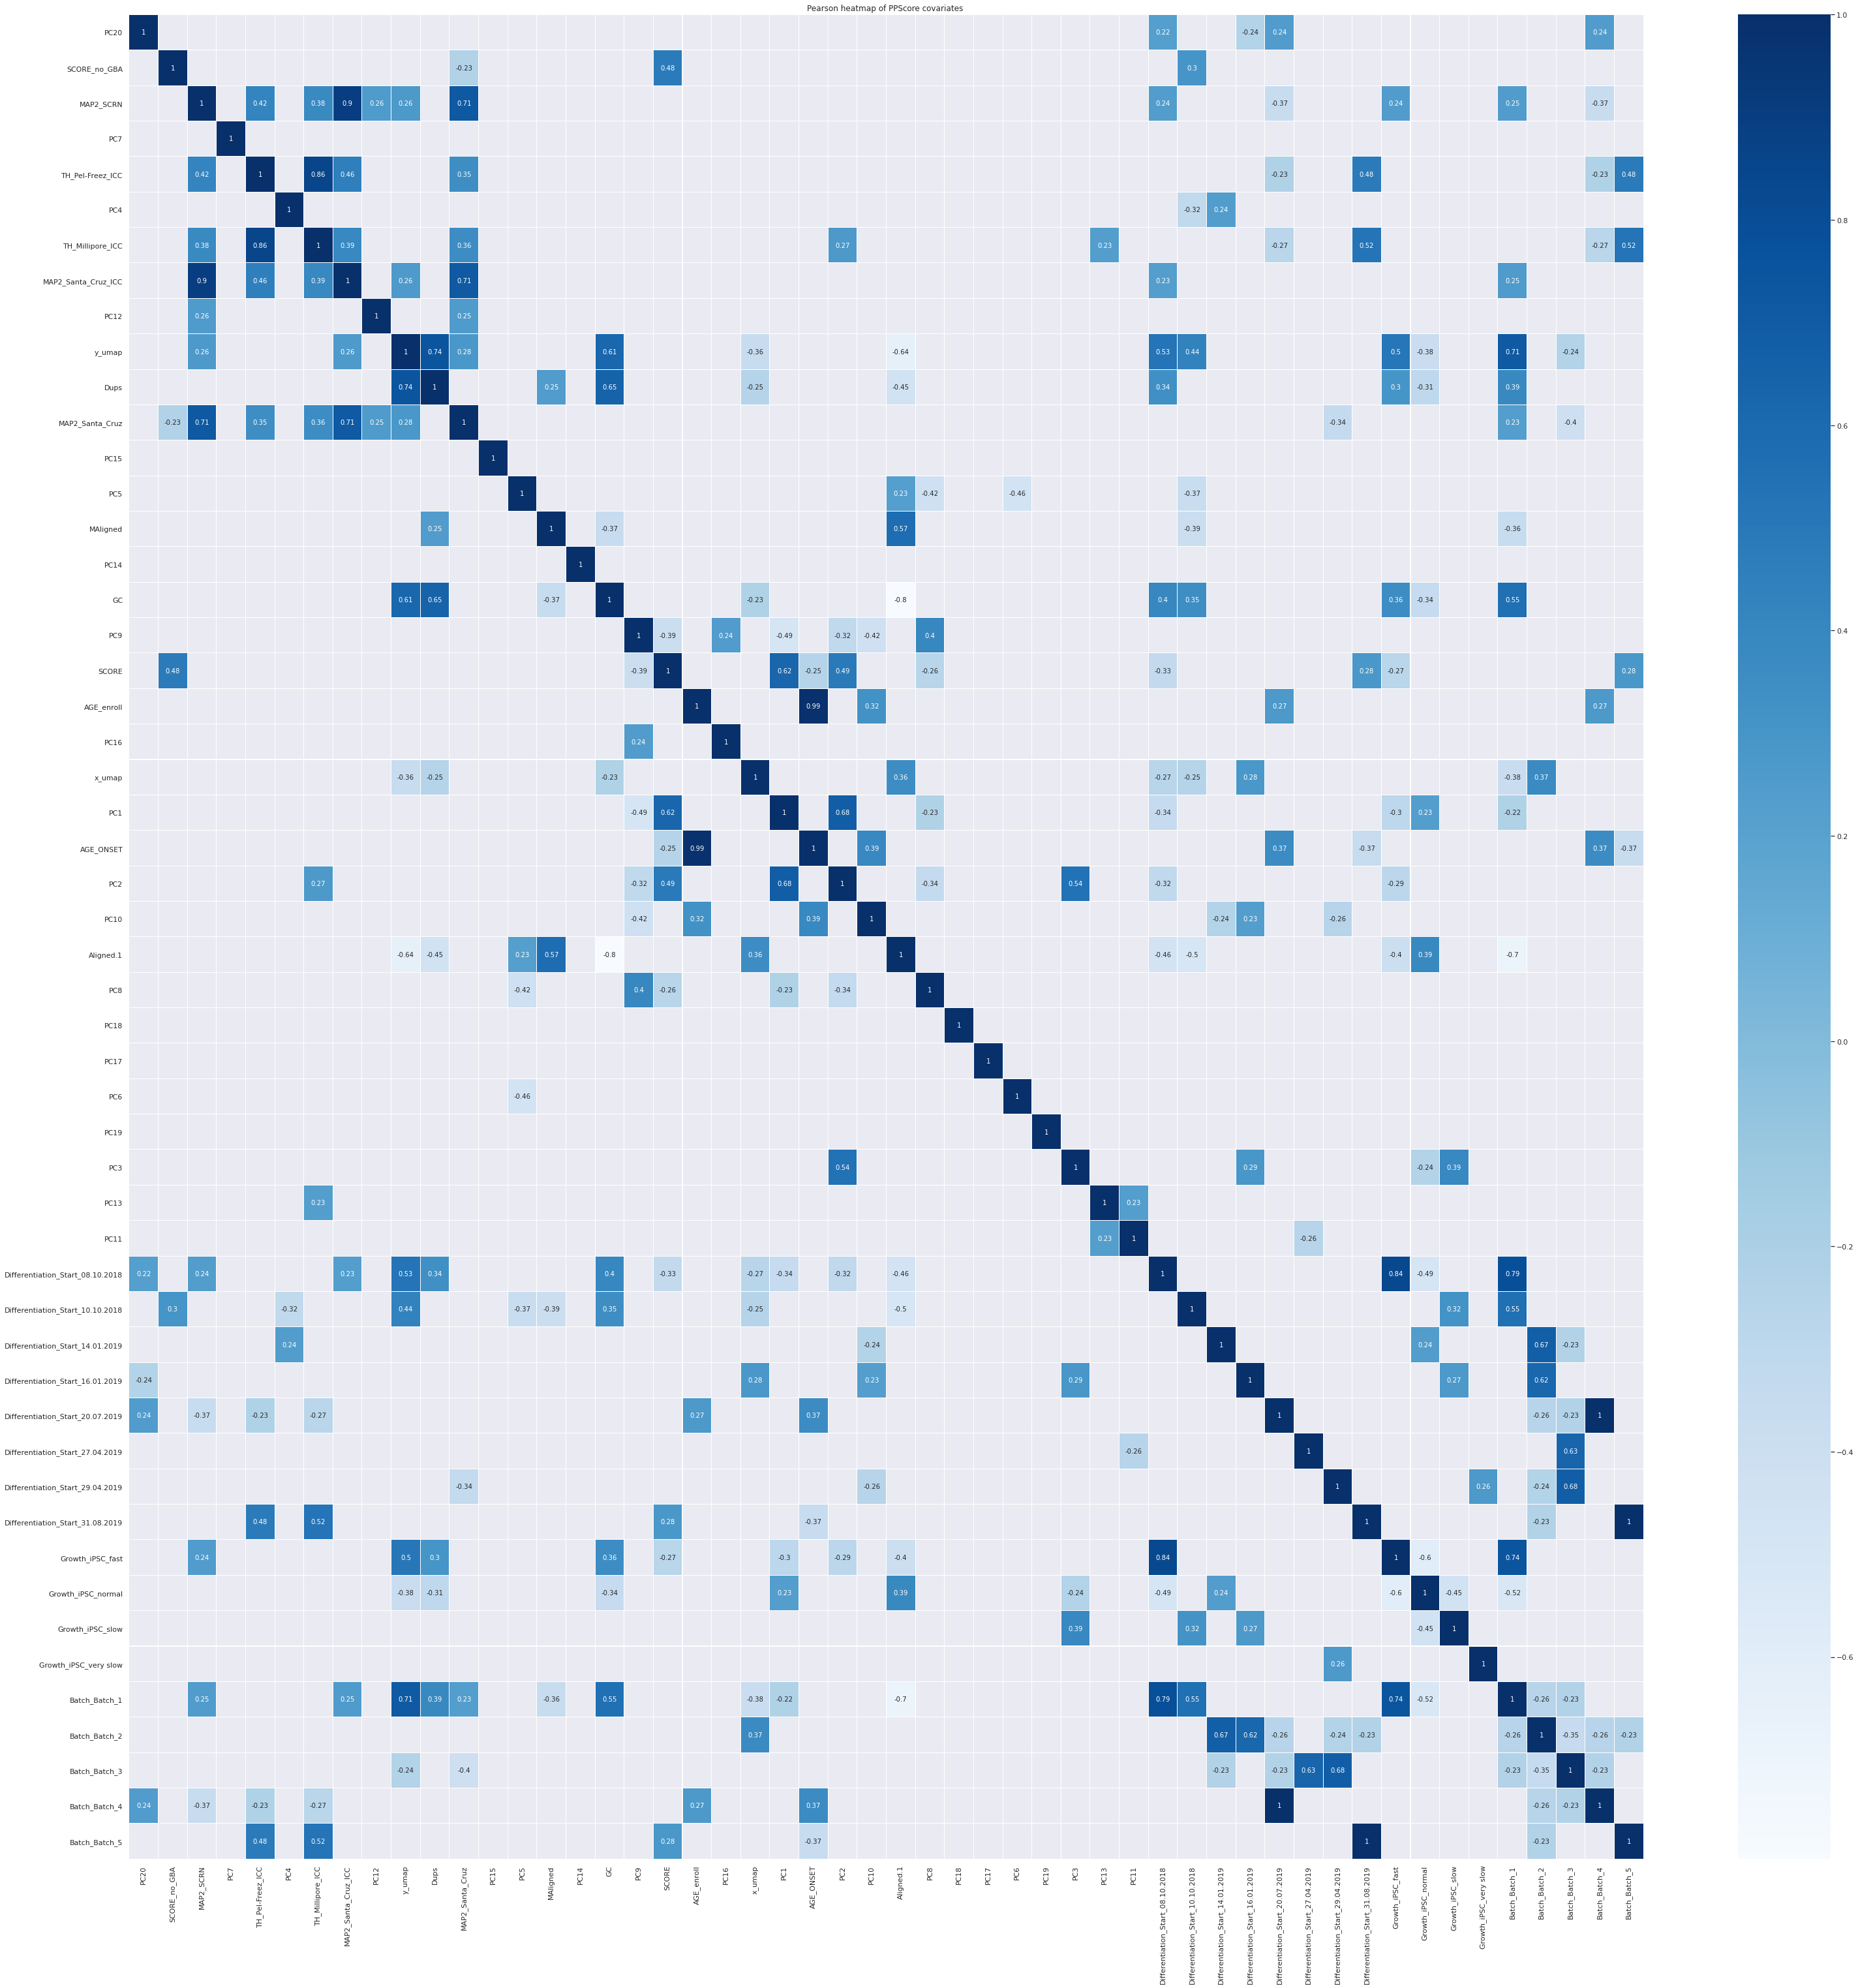

(16, 2)


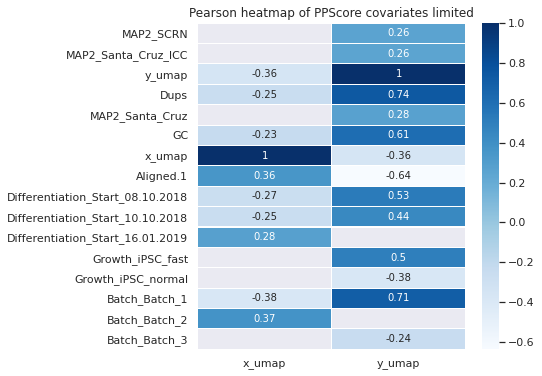

CPU times: user 29.2 s, sys: 892 ms, total: 30.1 s
Wall time: 30 s


In [36]:
%%time
umap_df = generate_umap_covs_df(quants_var_df[no_change_variance_features], covs_df)
covs_to_check = pps_predict_targets(umap_df, covs_target_list)
plot_ppscore_matrix(umap_df, covs_to_check, covs_target_list)
umap_dums_covs_df = dummy_covs_as_needed(umap_df[(set(covs_to_check) | 
                                                  set(covs_target_list))])
plot_correlation_heatmap(umap_dums_covs_df)
plot_correlation_heatmap(umap_dums_covs_df, covs_target_list)

#### plot umap of with known covariates of interest

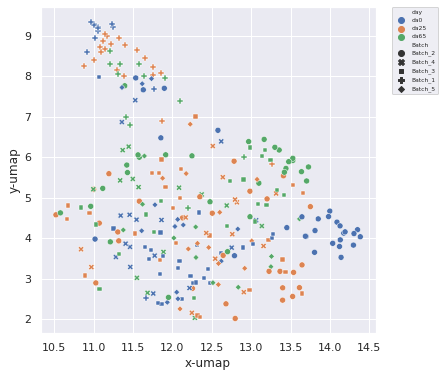

In [37]:
plot_umap_clusters(umap_df, hue_cov='day', style_cov='Batch')

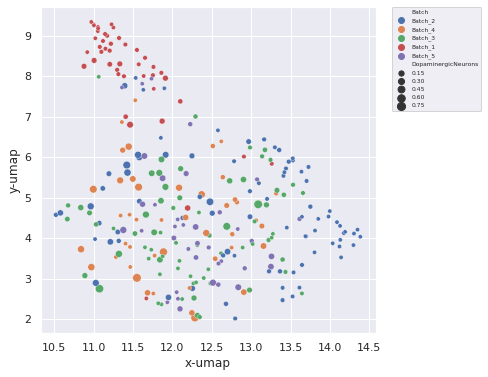

In [38]:
plot_umap_clusters(umap_df, hue_cov='Batch', size_cov='DopaminergicNeurons')

#### keep created covars and save them

In [39]:
# standardize the covariates
umap_covs_df = quantile_transform_df(umap_df[covs_target_list])
# now save the covariates
umap_covs_df.to_csv(umap_covs_file)

#### covariate adjust the normalized data by the covariates

In [40]:
# check to see in df's have same indices
if not traits_qtnorm_df.index.equals(umap_covs_df.index):
    print('indices are not equal re-index')
    umap_covs_df.reindex(traits_qtnorm_df.index)
    
traits_qtnorm_df.index.equals(umap_covs_df.index)    

True

In [41]:
%%time

residuals_df, cov_scores_df = covariate_residuals(traits_qtnorm_df, umap_covs_df)

#take a peek at the data
print(residuals_df.shape)
print(cov_scores_df.shape)

# print(cov_scores_df.head())

(301, 32108)
(32108, 1)
CPU times: user 21min 5s, sys: 23.7 s, total: 21min 28s
Wall time: 2min 41s


              score
count  32108.000000
mean       0.149685
std        0.150560
min        0.000000
25%        0.034000
50%        0.095000
75%        0.223000
max        0.795000


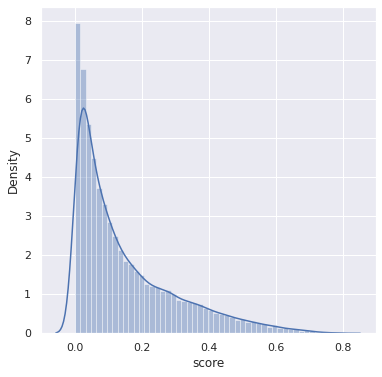

In [42]:
# get a summary of the covariates model scores
print(cov_scores_df.describe())
# look at the distribution of covariate model scores, 
# ie get a sense any gene driven by covariates
sns.set()
plt.figure(figsize=(6,6))
sns.distplot(cov_scores_df['score'])
plt.show()

#### save quantile normalized and covariate adjusted data

In [43]:
%%time 

residuals_df.to_hdf(adj_expr_file, key='expression', mode='w')

CPU times: user 145 ms, sys: 80.3 ms, total: 225 ms
Wall time: 222 ms


#### take a look at the normalized and covariate adjusted data

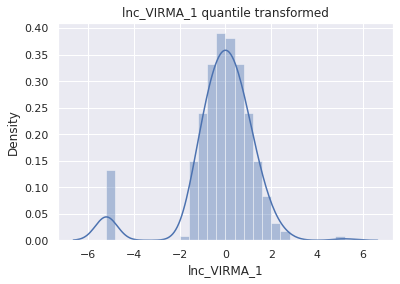

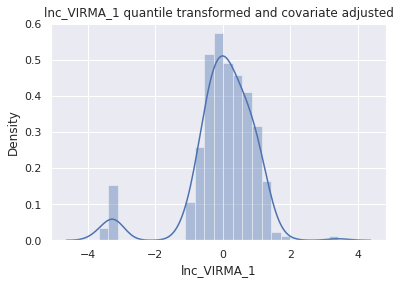

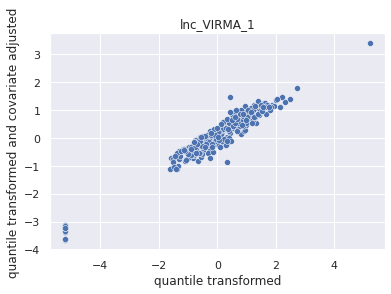

In [44]:
plot_trnsfrm_effect_example(traits_qtnorm_df, residuals_df)

        score
geneID       
FTX     0.795


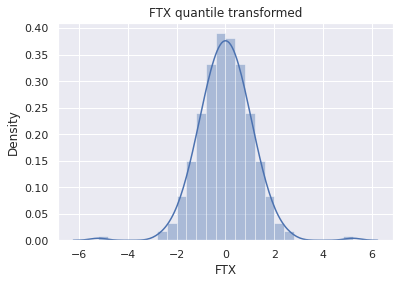

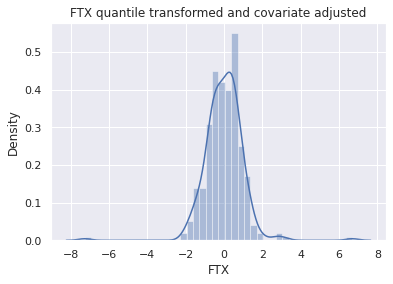

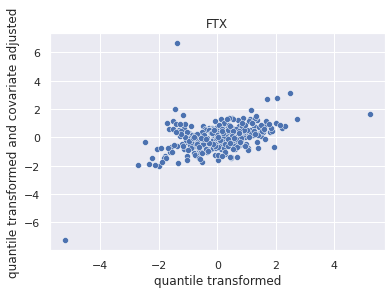

In [45]:
# find gene with largest score
large_adj_trait = cov_scores_df.loc[cov_scores_df['score'] == max(cov_scores_df['score'])]
print(large_adj_trait)
large_adj_traid_id = large_adj_trait.index.values[0]

# spot check same gene with largest adjustment effect
plot_trnsfrm_effect_example(traits_qtnorm_df, residuals_df, large_adj_traid_id)

#### what are the post normalization and covariate adjusted umap variables correlated with

The dimensions of the umap df and the traits are (301, 87)
x_umap


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,day,x_umap,0.902857,regression,True,mean absolute error,6.603114,0.641449,DecisionTreeRegressor()
1,y_umap,x_umap,0.879452,regression,True,mean absolute error,6.442329,0.776608,DecisionTreeRegressor()
2,ProliferatingFloorPlateProgenitors,x_umap,0.792293,regression,True,mean absolute error,6.603114,1.371511,DecisionTreeRegressor()
3,Ependymal-likeCells,x_umap,0.748816,regression,True,mean absolute error,6.603114,1.658596,DecisionTreeRegressor()
4,DopaminergicNeurons,x_umap,0.734237,regression,True,mean absolute error,6.603114,1.754861,DecisionTreeRegressor()
5,ImmatureDopaminergicNeurons,x_umap,0.719584,regression,True,mean absolute error,6.603114,1.851621,DecisionTreeRegressor()
6,EarlyneuronProgenitor,x_umap,0.718438,regression,True,mean absolute error,6.603114,1.859189,DecisionTreeRegressor()
7,LateneuronProgenitor,x_umap,0.661206,regression,True,mean absolute error,6.603114,2.237096,DecisionTreeRegressor()
8,Assigned,x_umap,0.169348,regression,True,mean absolute error,6.603114,5.484889,DecisionTreeRegressor()
9,GC,x_umap,0.074679,regression,True,mean absolute error,6.603114,6.110003,DecisionTreeRegressor()


y_umap


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,day,y_umap,0.869591,regression,True,mean absolute error,4.681375,0.610492,DecisionTreeRegressor()
1,x_umap,y_umap,0.865988,regression,True,mean absolute error,4.788688,0.641743,DecisionTreeRegressor()
2,ProliferatingFloorPlateProgenitors,y_umap,0.344060,regression,True,mean absolute error,4.681375,3.070700,DecisionTreeRegressor()
3,Ependymal-likeCells,y_umap,0.213432,regression,True,mean absolute error,4.681375,3.682220,DecisionTreeRegressor()
4,DopaminergicNeurons,y_umap,0.111944,regression,True,mean absolute error,4.681375,4.157325,DecisionTreeRegressor()
5,Assigned,y_umap,0.106671,regression,True,mean absolute error,4.681375,4.182010,DecisionTreeRegressor()
6,ImmatureDopaminergicNeurons,y_umap,0.098036,regression,True,mean absolute error,4.681375,4.222432,DecisionTreeRegressor()
7,EarlyneuronProgenitor,y_umap,0.097316,regression,True,mean absolute error,4.681375,4.225804,DecisionTreeRegressor()
8,LateneuronProgenitor,y_umap,0.065636,regression,True,mean absolute error,4.681375,4.374107,DecisionTreeRegressor()


found 21 covariates that may preditct target covariates
(117, 9)
(13, 13)


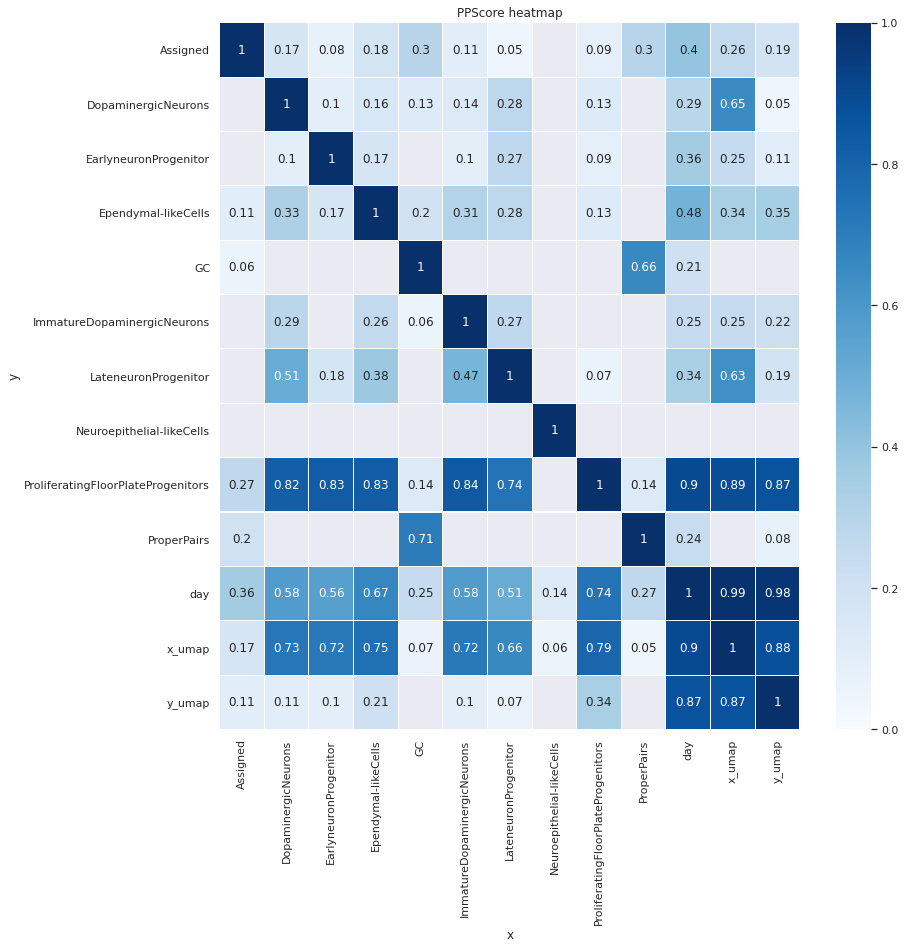

categoricals shape (301, 1)
one-hot encoded categoricals shape (301, 3)
new covs df shape (301, 16)
(15, 15)


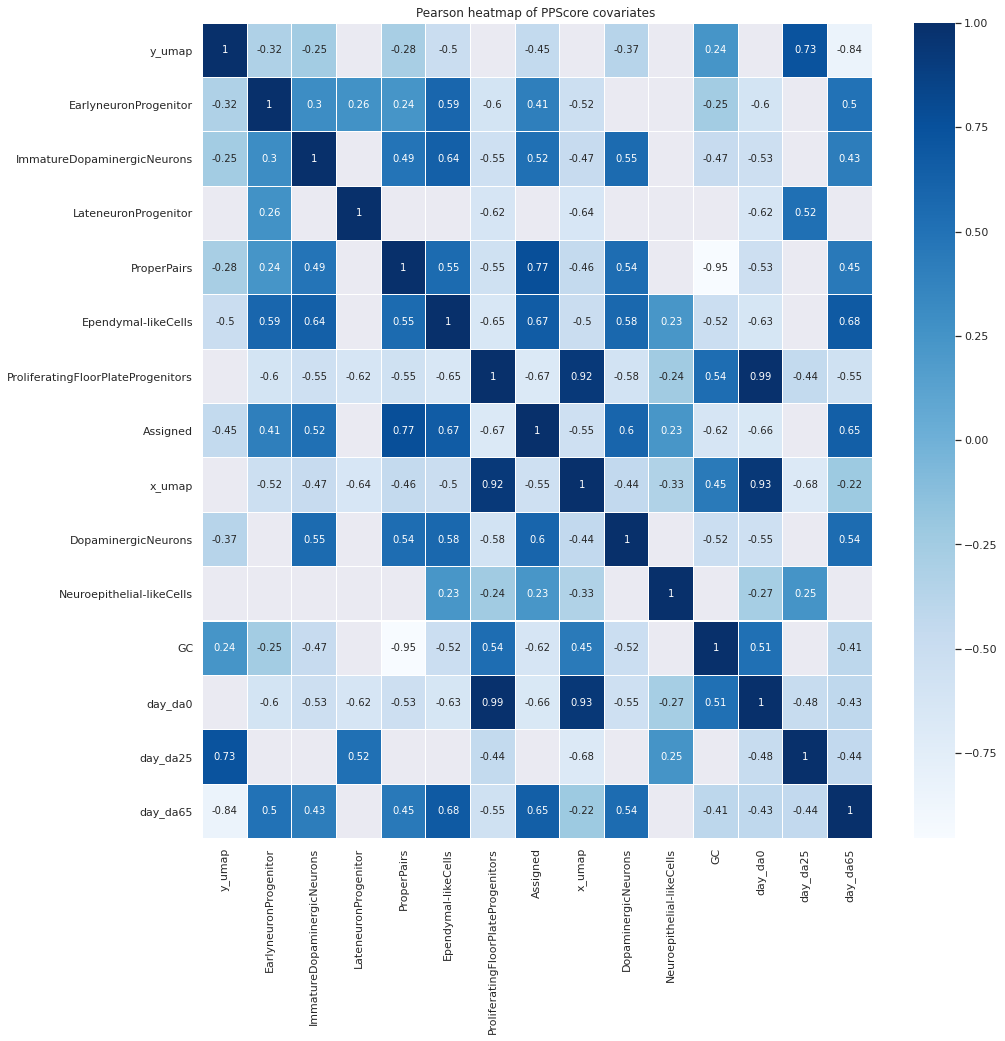

(15, 2)


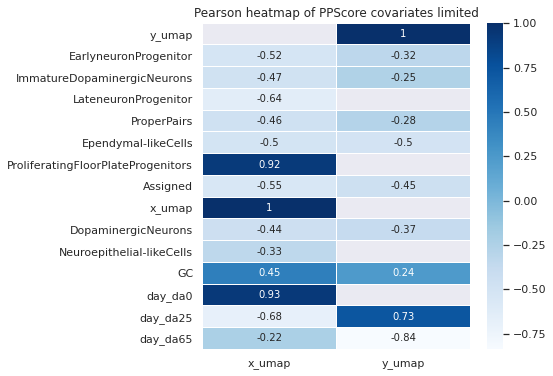

CPU times: user 10.3 s, sys: 268 ms, total: 10.5 s
Wall time: 10.5 s


In [46]:
%%time
umap_df = generate_umap_covs_df(residuals_df, covs_df)
covs_to_check = pps_predict_targets(umap_df, covs_target_list)
plot_ppscore_matrix(umap_df, covs_to_check, covs_target_list)
umap_dums_covs_df = dummy_covs_as_needed(umap_df[(set(covs_to_check) | 
                                                  set(covs_target_list))])
plot_correlation_heatmap(umap_dums_covs_df)
plot_correlation_heatmap(umap_dums_covs_df, covs_target_list)

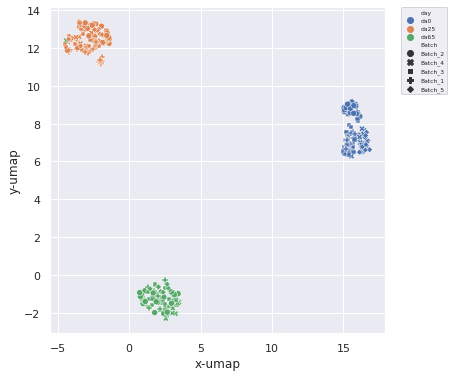

In [47]:
plot_umap_clusters(umap_df, hue_cov='day', style_cov='Batch')

#### looks like there is a da65 in the day25 group pull the ID

In [48]:
umap_df.loc[(umap_df['day'] == 'da65') & (umap_df['x_umap'] < 0)]

,x_umap,y_umap,day,SCORE_no_GBA,DIAG,diagnosis_at_baseline,DX_INIT,study_arm,MAP2_SCRN,BIRTHDT,...,Ependymal-likeCells,Batch,CNT2,PC18,PC17,PC6,PC19,PC3,PC13,PC11


#### since switching to tensorQTL can just use one large transcriptome pheno bed instead of per chrom pheno

In [49]:
# # get gene annots for present features
# gencode_present_df = gencode_df.loc[gencode_df['gene_id'].isin(residuals_df.columns)]
# # tensorQTL pheno bed is rows = features and columns = samples
# # where first four columns are chr, start, end, phenotype_id, then sample1 ... sampleN

# # create dict for renaming columns (samples) from assayid to geno_id
# sample_col_dict = id_map.set_index('assayid').to_dict()['sampleid']

# # transpose the residuals df from sample x feature to feature x sample
# tresiduals_df = residuals_df.transpose()

# # modify annots
# genes_df = gencode_present_df[['seqname', 'start', 'end', 'gene_id', 'strand']].copy()
# genes_df.rename(columns={'seqname': 'chr', 'start': 'fstart', 
#                          'end': 'fend'}, inplace=True)
# # for tensorQTL 'end' column is TSS so set appropriately
# genes_df['end'] = np.where(genes_df['strand'] == '+',  genes_df['fstart'], genes_df['fend'])
# genes_df['start'] = genes_df['end'] - 1
# # there is a feature per transcript, so can be multiple entries per gene, so just keep longest
# genes_df['length'] = genes_df['fend'] - genes_df['fstart']
# genes_df.sort_values(by=['gene_id', 'length'], inplace=True, ascending=False)
# print(genes_df.shape)
# genes_df.drop_duplicates(subset=['gene_id'], keep='first', inplace=True, ignore_index=True)
# genes_df.set_index('gene_id', inplace=True, drop=False)
# genes_df = genes_df.reindex(tresiduals_df.index)

# # insert the feature annots
# tresiduals_df.insert( 0, column='chr', value=genes_df['chr'])
# tresiduals_df.insert( 1, column='start', value=genes_df['start'])
# tresiduals_df.insert( 2, column='end', value=genes_df['end'])
# tresiduals_df.insert( 3, column='phenotype_id', value=genes_df['gene_id'])

# # now rename sample ids in columns
# tresiduals_df.rename(columns=sample_col_dict, inplace=True)

# tresiduals_df.to_csv(tnsrqtl_pheno_file, index=False, sep='\t')